# Assignment 4 - Image Denoising with Deep CNNs

### Name: Anirudh Swaminathan
### PID: A53316083
### Email ID: aswamina@eng.ucsd.edu

#### Notebook created by Anirudh Swaminathan from ECE department majoring in Intelligent Systems, Robotics and Control for the course ECE285 Machine Learning for Image Processing for Fall 2019

## Getting Started

In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

In [2]:
# select the relevant device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Creating noisy images of BSDS dataset with DataSet

#### Question 1

In [3]:
dataset_root_dir = '/datasets/ee285f-public/bsds/'

We have created the $dataset\_root\_dir$ and made it point to the BSDS dataset directory. 

#### Question 2

In [4]:
class NoisyBSDSDataset(td.Dataset):
    
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
        
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})".format(self.mode, self.image_size, self.sigma)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        
        # Read the original image
        clean = Image.open(img_path).convert('RGB')
        
        # choose i as random index to start the row crop from
        i = np.random.randint(clean.size[0] - self.image_size[0])
        
        # choose j as the random index to start the column crop from
        j = np.random.randint(clean.size[1] - self.image_size[1])
        # COMPLETE
        # crop the image
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        
        # transform and normalize
        transform = tv.transforms.Compose([
            # convert to torch tensor
            tv.transforms.ToTensor(),
            
            # Normalize each channel from [-1, 1]
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        # apply the transform on the image
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

I initially cropped the image to the requried image_size from the random indices that were generated using the $.crop()$ method. <br>
Then the image is converted to a torch tensor using the $tv.transforms.ToTensor()$ function. <br>
$$\textbf{NOTE:-} \text{The }tv.trasforms.ToTensor() \text{ converts the PIL image from range }(0, 255) \text{ to a tensor of range }(0, 1)$$
Finally, I normalize the image using the $tv.transforms.Normalize()$ function. <br>
This function takes means and standard deviations for each channel as the input. Since each channel has been transformed to $(0, 1)$ by the $tv.transforms.ToTensor()$ function, we have the mean for each channel is $0.5$ and the standard deviation is $0.5$. <br>
As given in the $PyTorch$ source code and documentation, the $tv.transforms.Normalize()$ function subtracts the mean for each channel from the image, and then divides by the standard deviation, so now the tensor in the range from $(0, 1)$ is converted to $\left( \frac{(0-0.5)}{0.5}, \frac{(1-0.5)}{0.5} \right)$, which is $(-1, 1)$. <br>
Finallly, as given in the question, the noisy image is generated by creating a torch tensor whose elements are individually sampled from the standard normal distribution $\mathcal{N} \sim \left(0, 1\right)$. <br>
This is then multiplied with the $\sigma$ that we require to convert it to $\mathcal{N} \sim \left(0, \sigma \right)$. <br>
Finally, the noisy image is normalized using the $\frac{2}{255}$ to ensure it is in the range of $(-1, 1)$.
This is because the $\sigma$ was for the origial pixel values with range from $0$ to $255$ and so, we divide by $255$. <br>
As discussed in Piazza, we then multiply by $2$ as the range of the values are doubled from $(0, 1)$ to $(-1, 1)$. <br>
Finally the noisy image is distributed as follows:- 
$$\text{noisy image} = \text{clean image} + \mathcal{N} \sim \left(0, \frac{2\sigma}{255}\right)$$

#### Question 3

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
# consider training set and the testing set from this class
train_set = NoisyBSDSDataset(root_dir=dataset_root_dir)
test_set = NoisyBSDSDataset(root_dir=dataset_root_dir, mode="test", image_size=(320, 320))

In [7]:
# 12th index image in the testing set
x = test_set.__getitem__(12)
noi = x[0]
cle = x[1]

In [8]:
print(type(noi), noi.dtype, noi.size(), noi.min(), noi.max())
print(type(cle), cle.dtype, cle.size(), cle.min(), cle.max())

<class 'torch.Tensor'> torch.float32 torch.Size([3, 320, 320]) tensor(-1.7797) tensor(1.9095)
<class 'torch.Tensor'> torch.float32 torch.Size([3, 320, 320]) tensor(-1.) tensor(1.)


<IPython.core.display.Javascript object>


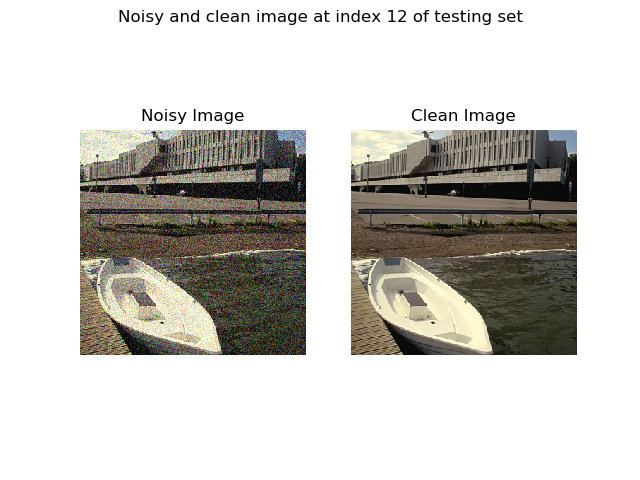

Text(0.5, 1.0, 'Clean Image')

In [9]:
# Display Noisy and Clean image for the 12th index of the testing set
fig, axes = plt.subplots(ncols=2)
fig.suptitle("Noisy and clean image at index 12 of testing set")

myimshow(noi, ax=axes[0])
axes[0].set_title("Noisy Image")

myimshow(cle, ax=axes[1])
axes[1].set_title("Clean Image")

Created $train\_set$ and $test\_set$ as instances of the $NoisyBSDSDataset$ class. <br>
Retrieved the item at index $12$ from the $test\_set$. <br>
Displayed the noisy and the clean images side-by-side for the $12^{th}$ index of the testing set, using the $myimshow()$ function that was given to us in the previous assignment.

## DnCNN

#### Question 4

In [10]:
# NNRegressor -> inherits from NeuralNetwork and implements criterion as MSE loss
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

I have now defined the class $NNRegressor$ that inherits from $NeuralNetwork$. <br>
I wrote that the $criterion$ must now be $MSELoss$ for the class $NNRegressor$.  <br>
This class is still abstract, as the $forward()$ method is still unimplemented.

#### Question 5

In [11]:
class DnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        """ Constructor
        D - Number of repetiitons of Conv + BN + ReLU
        C - Number of feature maps for each Conv layer
            default - 64
        """
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        # here padding=1 as we want to maintain the same size of the feature maps as given in input
        # this translates to "same" in convolutions, which means that we need to pad by (n-1)/2
        # hence, padding = (3-1)/2 = (2/2) = 1
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        # COMPLETE
        # I need to add D conv layers after this
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        
        # Add the final conv from 64 back to 3 feature maps
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        # BN layers
        self.bn = nn.ModuleList()
        
        # Append all the D Batch norm layers
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        # forward through all the layers
        for k in range(D):
            h = self.conv[k+1](h)
            h = F.relu(self.bn[k](h))
        # final layer forward
        # the x is added as a skip connection - ResNet
        y = self.conv[D+1](h) + x
        return y

I have now implemented the $DnCNN$ model, which inherits from $NNRegressor$. <br>
As given in the question, my $1^{st}$ convolution layer will take in $3$ feature maps and output $C = 64$ feature maps of equal size after $3 x 3$ convlutions. <br>
In order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use $0-$ padding. <br>
$$\textbf{Zero-padding calculation}$$
Our convolutional filter size is $3 x 3$. We need to output feature maps that are the same size as the input feature maps by using zero-padding. <br>
For a convolutional filter of size $n = 3$, the amount of zero-padding required for "same" convolution is given by
$$p = \frac{n - 1}{2} = \frac{3 - 1}{2} = \frac{2}{2} = 1$$
Hence, we give padding = $1$. <br>
$$\textbf{Adding the Conv layers}$$
The $1^{st}$ conv layer converts the input $3$ channels to $C$ channels, with the padding = $1$ to maintain the same size of the feature maps through the layers as argued above. <br>
We first append this layer to the $self.conv$ variable which is an instance of the $ModuleList$ object. <br>
We have $D = 6$ conv layers that repeat, so we iteratively append conv layers $D$ times, where each takes in $C$ features in the input, and outputs $C$ features, to the $self.conv$ variable which is a $ModuleList$ object. <br>
The padding is $1$ as argued above, to maintain the same size of feature maps through the layers. <br>
The final conv layer that is appended is the one that converts $C$ input features to $3$ output features back again. The padding still remains $1$ to ensure the size of the feature maps remains the same as argued above. <br>
Thus, we have a total of $D + 2$ conv layers in the $self.conv$ $ModuleList$, which are indexed from $0$ to $D + 1$. <br>
$$\textbf{Adding the BatchNorm layers}$$
We have a total of $D$ $BatchNorm2d$ layers. We iteratively append bn layers $D$ times, where each takes in $C$ features in the input, to the $self.bn$ variable which is a $ModuleList$ object. <br>
Thus, we have a total of $D$ bn layers in the $self.bn$ $ModuleList$, which are indexed from $0$ to $D - 1$. <br>
$$\textbf{Implementing the forward() method}$$
In the $forward()$ method, as given in the question, I sequentially pass the input tensor $x$ through the $1^{st}$ conv layer, which is given by the index $0$ of the $self.conv$ $ModuleList$ object. <br>
I then iteratively pass the tensor obtained from the previous step through the $D$ conv layers first, and then through the $D$ BN layers. <br>
$\textbf{NOTE: }$ Since I've already used the $1^{st}$ conv layer initially, my index in the iteration for conv layers from the $self.conv$ $ModuleList$ object is $k + 1$, where $k$ denotes the iteration index. <br>
The index for the $BatchNorm2d$ layers remains $k$, as all my $D$ bn layers are yet to be applied. <br>
I additionally pass the tensor obtained from each bn layer through $ReLU$. <br>
I apply the final conv layer on the tensor obtained after $D$ iterations, using the index $D + 1$. This is the $(D + 2)^{th}$ element of the $self.conv$ $ModuleList$ object. This conv layer converts the $C$ feature maps obtained back to $3$ feature maps, with the same image size with padding = $1$ as argued above. <br>
I then add the input tensor $x$ to this output, thus implementing my skip-connection. <br><br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 6

In [12]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
        
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        
        # compute the difference for all 3 channels for all the images in the minibatch
        diff = y - d
        
        # calculate the total number of elements in the tensor
        n = y.numel()
        
        # calaulate the difference squared
        diff_sq = diff ** 2
        
        # calculate the norm squared
        norm_sq = torch.sum(diff_sq)
        
        # psnr is now taken
        psnr = 10 * torch.log10((4 * n) / norm_sq)
        self.running_psnr += psnr
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        
        # average psnr when called
        psnr_avg = self.running_psnr / self.number_update
        return {'loss' : loss, 'psnr' : psnr_avg}

Created a subclass $DenoisingStatsManager$ that inherits from $StatsManager$ and overloads each method. <br>
The PSNR is calculated by the given formula
$$PSNR = 10 \log_{10} \left( \frac{4n}{\| y - d \|_2^2} \right)$$
I find the total number of elements in the input tensor, which is given by
$$n = \text{Number of elements in minibatch} * \text{Number of channels} * \text{Image Width} * \text{Image Height}$$
I calculate $\| y - d \|_2^2$ as the sum of the errors squared of $y$ and $d$. <br>
The additional information apart from the running loss is the running PSNR that is also being tracked here. <br>
In $init()$, the running PSNR is set to $0$. The $accumulate()$ method adds the PSNR for each minibatch to the running PSNR. <br>
Finally, the $summarize()$ method is overloaded to set the PSNR to the average over all the updates in the epoch. <br>

#### Question 7

In [13]:
# DnCNN network
lr = 1e-3

# create dncnn with D = 6
dncnn_net = DnCNN(D=6)

# transferred the net to GPU
dncnn_net = dncnn_net.to(device)
adam = torch.optim.Adam(dncnn_net.parameters(), lr=lr)
dncnn_stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(dncnn_net, train_set, test_set, adam,
                     dncnn_stats_manager, output_dir="denoising1",
                     batch_size=4, perform_validation_during_training=True)

I have created a $DnCNN$ network with $D = 6$ and transferred it to the $GPU$. <br>
I also created and experiment for $DnCNN$ named $exp1$ using Adam optimizer with learning rate as $10^-3$. <br>
I am using an instance of the $DenoisingStatsManager$ class for computing statistics. <br>
Finally, I am using mini-batches of size $4$ and store the checkpoints in $denoising1$ directory. <br>
I finally checked that the directory has been created.

#### Question 8

In [14]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    
    # setup the axes
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    
    # show the noisy image
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title("Noisy image")
    
    # COMPLETE
    # show the denoised image
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title("Denoised image")
    
    # plots now
    # Plot the training loss over the epochs
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                label="training loss")
    # Plot the evaluation loss over the epochs
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                color='orange', label="test loss")
    # legend for the plot
    axes[1][0].legend()
    # xlabel and ylabel
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")
    
    # Plot the training accuracy over the epochs
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)],
                label="training psnr")
    # Plot the evaluation accuracy over the epochs
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)],
                color='orange', label="test psnr")
    # legend for the plot
    axes[1][1].legend()
    # xlabel and ylabel
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")
    
    plt.tight_layout()
    fig.canvas.draw()

I have completed the $plot()$ function to plot the original and denoised images and the different metrics for $200$ epochs. <br>
I use a $4*4$ subplots for the same. <br>
The $1^{st}$ row of plot is for the noisy and the denoised image respectively. <br> 
The next row corresponds to the training and evaluation metrics, i.e., the training and evaluation loss and PSNR. <br>
I access the $k^{th}$ epoch using the $history[k]$ index. <br>
I then access the metrics evaluated on the training set using the $0^{th}$ index. I access the metrics evaluated on the validation set using the $1^{st}$ index. <br>
To access the loss, we use the loss as key value for the dictionary. To access the PSNR, we use psnr as the key value for the dictionary. <br>
To get the orange colour for the plot, we use the $color="orange"$ as another parameter in the $plot()$ function in the axes. <br>
To set the X Label and Y Label for each subplot, we use the $set\_xlabel()$ and the $set\_ylabel()$ methods respectively. <br>
To set the legend for the subplots, since we have already specified the $label$ for each subplot, we just need to call the $legend()$ function for each subplot. <br>

<IPython.core.display.Javascript object>


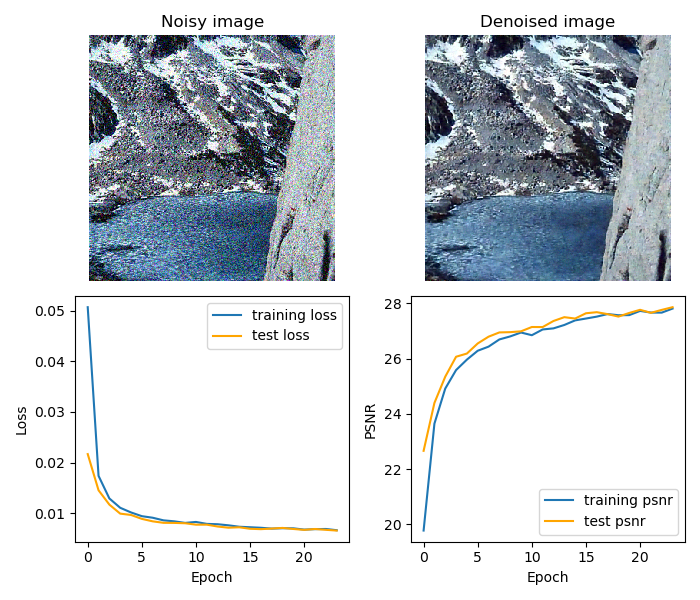

Start/Continue training from epoch 23
Epoch 24 (Time: 75.47s)
Epoch 25 (Time: 77.00s)


KeyboardInterrupt: 

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))